<a href="https://colab.research.google.com/github/abhinav-exp/Forecasting-CryptoCurrency-Prices/blob/master/TFLANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)

In [3]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x)
  return pd.DataFrame(X)

data2 = split_sequence(data1, 10)
print(data2.shape)
print(data2)

(771, 10)
           0        1        2         3         4         5         6  \
0    2515.25  2596.98  2725.08   2643.35   2679.99   2690.76   2574.84   
1    2596.98  2725.08  2643.35   2679.99   2690.76   2574.84   2505.61   
2    2725.08  2643.35  2679.99   2690.76   2574.84   2505.61   2407.91   
3    2643.35  2679.99  2690.76   2574.84   2505.61   2407.91   2575.75   
4    2679.99  2690.76  2574.84   2505.61   2407.91   2575.75   2553.12   
..       ...      ...      ...       ...       ...       ...       ...   
766  9751.24  9880.67  9841.96   9468.92   9549.70   9503.32   9580.00   
767  9880.67  9841.96  9468.92   9549.70   9503.32   9580.00  10099.00   
768  9841.96  9468.92  9549.70   9503.32   9580.00  10099.00  10417.24   
769  9468.92  9549.70  9503.32   9580.00  10099.00  10417.24  10533.07   
770  9549.70  9503.32  9580.00  10099.00  10417.24  10533.07  10820.75   

            7         8         9  
0     2505.61   2407.91   2575.75  
1     2407.91   2575.75   255

In [4]:
train_x = data2.iloc[:int(0.85*len(data2)), :9]
train_y = data2.iloc[:int(0.85*len(data2)), 9:10]
test_x = data2.iloc[int(0.85*len(data2)):, :9]
test_y = data2.iloc[int(0.85*len(data2)):, 9:10]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(655, 9)
(655, 1)
(116, 9)
(116, 1)


In [5]:
qqqq = 2*np.random.random((3, 1)) - 1
print(np.sin(qqqq))

[[-0.51498447]
 [-0.22718357]
 [ 0.28774048]]


In [6]:
s = np.sin(qqqq)
c = np.cos(qqqq)
print(s)
print(c)
print(qqqq + s + c)

[[-0.51498447]
 [-0.22718357]
 [ 0.28774048]]
[[0.85719951]
 [0.97385195]
 [0.95770842]]
[[-0.19877451]
 [ 0.51748373]
 [ 1.5373156 ]]


In [47]:
class TFLANN():
  def __init__(self):
    self.weight_matrix = 2*np.random.random((9*3, 1)) - 1
  
  def func_x(self, x):
    orginal_x = x
    sinned_x = np.sin(np.pi*x)
    cossed_x = np.cos(np.pi*x)
    functioned_x = np.hstack((x, sinned_x, cossed_x))
    return functioned_x

  def tanh_derivative(self, x):
    return 1.0 - (np.tanh(x) ** 2)

  def forward_propagation(self, x):
    funced_x = self.func_x(x)
    return np.dot(funced_x, self.weight_matrix)

  def train(self, train_x, train_y, epochs):
    for iteration in range(epochs):
      y = self.forward_propagation(train_x)

      error = train_y - y

      adjustment = np.dot(self.func_x(train_x).T, error * self.tanh_derivative(y))

      self.weight_matrix += adjustment
      # for w in self.weight_matrix:
      #   print(str(round(w[0], 2)) + " ", end="")
      # print("epoch ")

In [48]:
model = TFLANN()
model.train(train_x = train_x, train_y = train_y, epochs = 1000)
preds = model.forward_propagation(test_x)
print(preds.shape)

(116, 1)


In [49]:
preds[:, 0]

array([10414.97276231, 10305.72768838, 10351.00146216, 10248.36575269,
       10099.21811004, 10296.87938392, 10020.57717134, 10382.68985312,
       10409.14898882, 10546.18827155, 10447.32654031, 10793.48117578,
       10726.97824722, 10719.90073217, 10641.3646292 , 10569.72034275,
       10431.7061357 , 10461.39881135, 10444.10018144, 10238.9445749 ,
       10165.24283477, 10616.02728456, 10797.00552605, 10959.91056939,
       11154.04756298, 11379.70694016, 11461.09973169, 11673.99819738,
       12040.11015768, 12368.8664104 , 12669.41791588, 13350.27204371,
       14199.52557961, 14881.82390938, 15469.78790174, 15649.58635501,
       16123.29101497, 15365.04138656, 16213.49840842, 15660.83720427,
       15710.78381828, 15227.37142917, 15250.13060171, 15751.93461112,
       16798.28692016, 16133.65969216, 16535.50505913, 16706.78603463,
       17231.16347547, 17178.1066958 , 17217.19780463, 17635.97735015,
       16924.32023004, 16522.44893916, 16319.56764666, 15748.73639247,
      

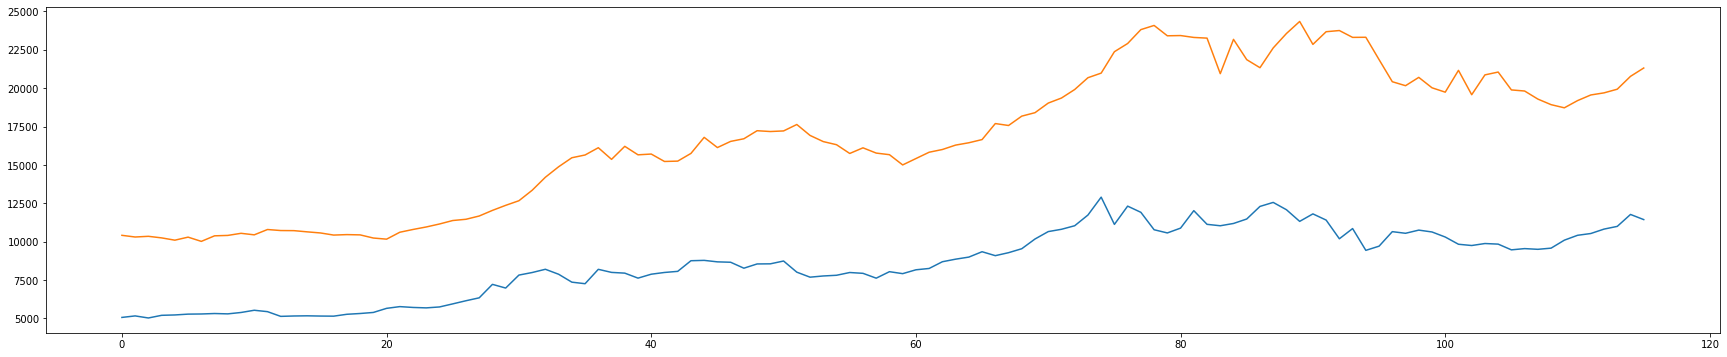

In [50]:
plt.figure(figsize=(30, 6))
plt.plot(test_y.reset_index()[9])
plt.plot(preds)
plt.show()
     